In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import os

In [2]:
home = Path.home()
data_path = os.path.join(home, "OneDrive", "Documents", "GitHub", "sodium-ion-batteries", "data_annotated", "annotated_data.json")
model_name = "batterydata/batterybert-cased-abstract"

In [3]:
# === Step 1: Prepare Data ===
texts = []
labels = []
with open(data_path, "r", encoding='utf-8') as file:
    data = json.load(file)
    texts = data["text"]
    labels = data["label"]

# # Map labels to integers
# label_mapping = {"Irrelevant": 0, "Relevant": 1}
# numerical_labels = [label_mapping[label] for label in labels]
# numerical_labels = labels

In [4]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_labels = len(label_encoder.classes_)

In [5]:
data = {'text': texts, 'label': encoded_labels}
dataset = Dataset.from_dict(data)

In [6]:
train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = train_testvalid['train']
eval_dataset = test_valid['train']
test_dataset = test_valid['test']


In [7]:
model_name = "batterydata/batterybert-cased-abstract"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)


C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)


In [12]:
trainer.train()


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8497406244277954, 'eval_accuracy': 0.4666666666666667, 'eval_precision': 0.4666666666666667, 'eval_recall': 0.4666666666666667, 'eval_f1': 0.4666666666666667, 'eval_runtime': 0.128, 'eval_samples_per_second': 117.182, 'eval_steps_per_second': 15.624, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5971750020980835, 'eval_accuracy': 0.6, 'eval_precision': 0.6222222222222221, 'eval_recall': 0.6, 'eval_f1': 0.56, 'eval_runtime': 0.1259, 'eval_samples_per_second': 119.145, 'eval_steps_per_second': 15.886, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6312395930290222, 'eval_accuracy': 0.6, 'eval_precision': 0.6222222222222221, 'eval_recall': 0.6, 'eval_f1': 0.56, 'eval_runtime': 0.11, 'eval_samples_per_second': 136.385, 'eval_steps_per_second': 18.185, 'epoch': 3.0}
{'train_runtime': 13.5453, 'train_samples_per_second': 26.577, 'train_steps_per_second': 3.322, 'train_loss': 1.44813232421875, 'epoch': 3.0}


TrainOutput(global_step=45, training_loss=1.44813232421875, metrics={'train_runtime': 13.5453, 'train_samples_per_second': 26.577, 'train_steps_per_second': 3.322, 'total_flos': 94719979929600.0, 'train_loss': 1.44813232421875, 'epoch': 3.0})

In [16]:
training_logs = trainer.state.log_history
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for log in training_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])


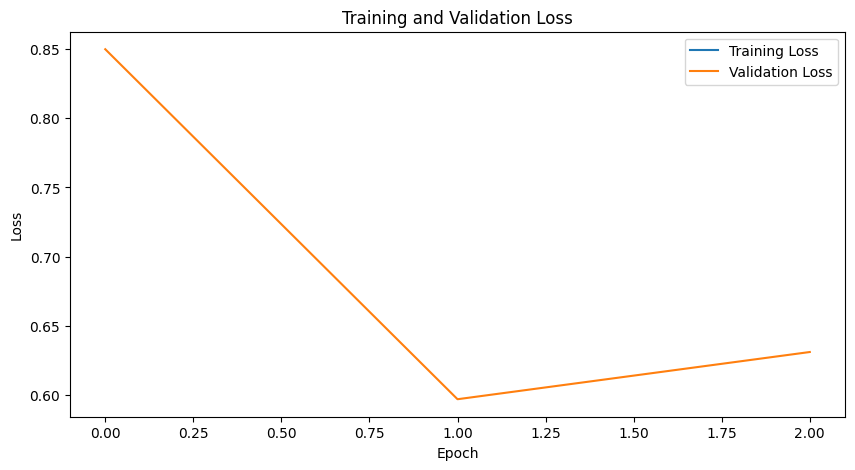

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot([0,1,2], [0.8497406244277954, 0.5971750020980835, 0.6312395930290222], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# test_dataset = test_dataset.map(tokenize_function, batched=True)
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# metrics = trainer.evaluate(test_dataset)
# print(metrics)


Map:   0%|          | 0/15 [00:00<?, ? examples/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6187614798545837, 'eval_accuracy': 0.6, 'eval_precision': 0.6545454545454545, 'eval_recall': 0.6, 'eval_f1': 0.5777777777777777, 'eval_runtime': 0.3122, 'eval_samples_per_second': 48.042, 'eval_steps_per_second': 6.406, 'epoch': 3.0}
